# Reporte Técnico (segunda entrega) 

## Implementación de todos los modelos de regresión 

## ¿Qué factores predicen mejor un retraso en la entrega? 

### Delivery_days vs. freight_value

El objetivo de incluir esta regresion es evaluar si con freight value es posible explicar los dias de entrega, aún asi evaluaremos si es viable 


In [ ]:
# Convertir fechas a tipo datetime
orders_dataset['order_purchase_timestamp'] = pd.to_datetime(orders_dataset['order_purchase_timestamp'])
orders_dataset['order_delivered_customer_date'] = pd.to_datetime(orders_dataset['order_delivered_customer_date'])

# Crear variable delivery_days
orders_dataset['delivery_days'] = (orders_dataset['order_delivered_customer_date'] - orders_dataset['order_purchase_timestamp']).dt.days

# Unir orders con order_items
datar1 = pd.merge(orders_dataset, order_items_dataset, on='order_id', how='inner')
# Unir con customers
datar1 = pd.merge(datar1, customers_dataset[['customer_id', 'customer_state', 'customer_zip_code_prefix']], on='customer_id', how='left')

# Unir con sellers
datar1 = pd.merge(datar1, sellers_dataset[['seller_id', 'seller_state', 'seller_zip_code_prefix']], on='seller_id', how='left')

# Unir con products
datar1 = pd.merge(datar1, products_dataset[['product_id', 'product_category_name', 'product_weight_g']], on='product_id', how='left')

# Unir con payments
datar1 = pd.merge(datar1, order_payments_dataset[['order_id', 'payment_type', 'payment_installments', 'payment_value']], on='order_id', how='left')

# Unir con reviews
datar1 = pd.merge(datar1, order_reviews_dataset[['order_id', 'review_score']], on='order_id', how='left')


In [ ]:
# Crear variable nueva de distancia aproximado
geo_avg = geolocation_dataset.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# Coordenadas del cliente
datar1 = pd.merge(datar1, geo_avg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
datar1.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}, inplace=True)

# Coordenadas del vendedor
datar1 = pd.merge(datar1, geo_avg, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
datar1.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)


In [ ]:
# Generacion de distancia 

def haversine(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Fórmula Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Radio de la Tierra en km
    return km

# Calcular distancia
datar1['distance'] = haversine(datar1['customer_lat'], datar1['customer_lng'], datar1['seller_lat'], datar1['seller_lng'])

#limpieza de datos
# Nos quedamos con las variables clave
reg_data = datar1[['delivery_days', 'freight_value', 'distance', 'price', 'product_weight_g']]

# Eliminamos registros con valores nulos
reg_data = reg_data.dropna()



Resultados Regresión Lineal Simple (freight_value ➜ delivery_days):
MAE  = 6.08 días
RMSE = 9.25 días
R²   = 0.0462


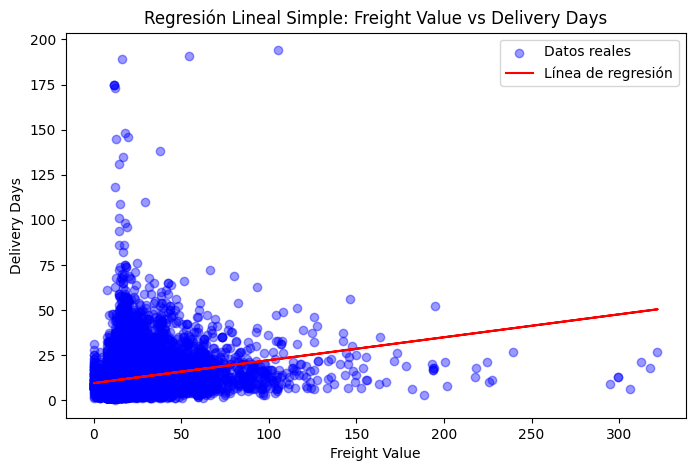

In [ ]:
# Por ultimo tocara generar la regresion lineal simple

# 1. Definir variable independiente (X) y dependiente (y)
X = reg_data[['freight_value']]  # Variable predictora
y = reg_data['delivery_days']    # Variable objetivo

# 2. Dividir en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear y entrenar el modelo
model_lr_simple = LinearRegression()
model_lr_simple.fit(X_train, y_train)

# 4. Hacer predicciones
y_pred = model_lr_simple.predict(X_test)

# 5. Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Resultados Regresión Lineal Simple (freight_value ➜ delivery_days):")
print(f"MAE  = {mae:.2f} días")
print(f"RMSE = {rmse:.2f} días")
print(f"R²   = {r2:.4f}")

# dibujo 
plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, color='blue', alpha=0.4, label='Datos reales')
plt.plot(X_test, y_pred, color='red', label='Línea de regresión')
plt.xlabel('Freight Value')
plt.ylabel('Delivery Days')
plt.title('Regresión Lineal Simple: Freight Value vs Delivery Days')
plt.legend()
plt.show()

Conclusión RL1


El modelo no es bueno para predecir delivery_days usando solo freight_value.

Esto era esperable, ya que el tiempo de entrega depende de muchos más factores (distancia, logística, tipo de producto, estado, etc.).

Esta regresión sirve como un baseline inicial para comparar con modelos más complejos.

### Regresion lineal múltiples 


Al poder evaluar los valores de los resultados de la regresión pasada podemos evaluar que quedo bastante pobre de manera que si integramos mas variables independientes es posible que tengamos mejores resultados y evaluar tambien que afecta al los dias de entrega

In [ ]:
# Selección de variables
features = ['freight_value', 'distance', 'price', 'product_weight_g', 
            'payment_installments', 'payment_type', 
            'product_category_name', 'customer_state', 'seller_state']

X = datar1[features]
y = datar1['delivery_days']

# Eliminamos registros con nulos en estas columnas
data_multi = pd.concat([X, y], axis=1).dropna()
X = data_multi[features]
y = data_multi['delivery_days']

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=['payment_type', 'product_category_name', 'customer_state', 'seller_state'], drop_first=True)

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)



In [ ]:
# entrenar el modelo de regresion multiple 
# Crear y entrenar el modelo
model_lr_multi = LinearRegression()
model_lr_multi.fit(X_train, y_train)

# Predicciones
y_pred_multi = model_lr_multi.predict(X_test)

# Evaluación
mae_multi = mean_absolute_error(y_test, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

print(f"Resultados Regresión Lineal Múltiple:")
print(f"MAE  = {mae_multi:.2f} días")
print(f"RMSE = {rmse_multi:.2f} días")
print(f"R²   = {r2_multi:.4f}")


Resultados Regresión Lineal Múltiple:
MAE  = 5.28 días
RMSE = 8.37 días
R²   = 0.2215


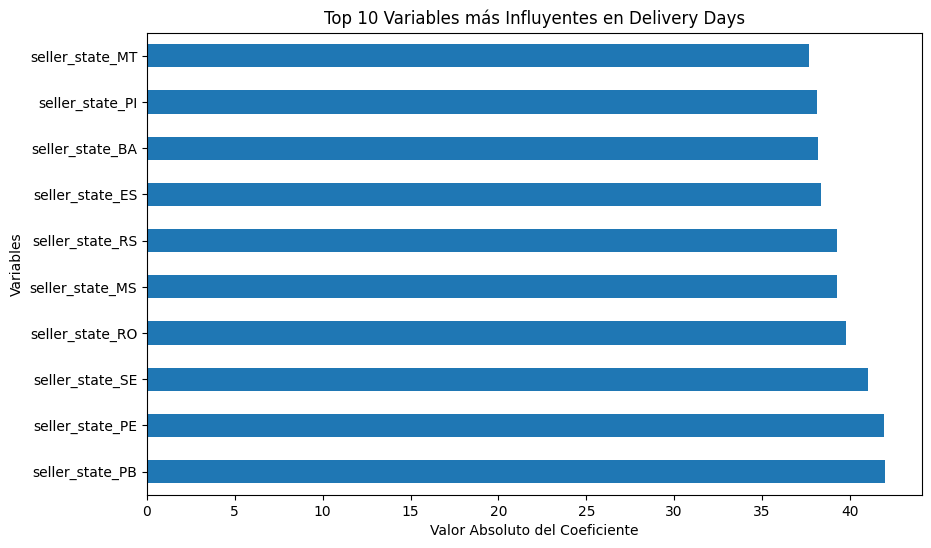

In [ ]:
# visualizacion de regresion multiple (coeficientes)

# Extraer los coeficientes del modelo
coeficientes = pd.Series(model_lr_multi.coef_, index=X_encoded.columns)

# Seleccionar los 10 coeficientes más influyentes (por valor absoluto)
coef_importantes = coeficientes.abs().sort_values(ascending=False).head(10)

# Graficar
plt.figure(figsize=(10,6))
coef_importantes.plot(kind='barh')
plt.title('Top 10 Variables más Influyentes en Delivery Days')
plt.xlabel('Valor Absoluto del Coeficiente')
plt.ylabel('Variables')
plt.show()


### Conclusiones

Gracias a esta regresion lineal multiple podemos evaluar como Antes teníamos un R² de 0.0462, ahora subimos a 0.2215 Esto indica que ahora el modelo explica mejor variabilidad en los tiempos de entrega.

Y gracias a la grafica podemos ver que las variables mas "impactantes" son los estados donde se encuentran los vendedores ua que tienen un impacto significativo en los tiempos de entrega.

### IMPLEMENTACION DE REGRESION KNN

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Dividimos en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:


# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(X_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(X_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")


Resultados KNN Regression:
MAE  = 5.33 días
RMSE = 8.64 días
R²   = 0.1719


Al ser variables tan dispersas podemos ver que la regresion lineal multiple nos favorecio mas con el acercamiento del resultado esperado, no obstante podemos ver que tiene cierta relacion incluso viendo el MAE que esta cercano 


### Implementacion de regresion SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Aplicar muestreo al set de entrenamiento
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=5000, random_state=42)

# 2. Crear el modelo SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_sample, y_train_sample)

# 3. Predicciones (usamos el test completo para evaluar)
y_pred_svr = svr_model.predict(X_test)

# 4. Evaluación
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Resultados SVR (con muestreo de 5000 registros):")
print(f"MAE  = {mae_svr:.2f} días")
print(f"RMSE = {rmse_svr:.2f} días")
print(f"R²   = {r2_svr:.4f}")


Resultados SVR (con muestreo de 5000 registros):
MAE  = 5.15 días
RMSE = 8.78 días
R²   = 0.1438


## Proceso de ajuste de parámetros